In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import src.utils.time
import src.utils.dict

from time import time
from datetime import datetime

import pprint
import math

---

# Load experiment data

In [2]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

In [3]:
exp_data_all = {}

In [4]:
exp_data_all["ret_train"] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train")

backbone_list = [
    "convnext_t"
]

exp_idxs_list = [
    [2]
]

for backbone, exp_idxs in zip(backbone_list, exp_idxs_list):

    exp_data_all["ret_train"][backbone] = {}
    
    for exp_idx in exp_idxs:

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data_corr.json")
        exp_data = load_json_dict(exp_filename)

        exp_data_all["ret_train"][backbone]["exp_{:03d}".format(exp_idx)] = exp_data

    print()

In [5]:
exp_data_all["ret_train_pyr"] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train_pyr")

backbone_list = [
    "convnext_t_s1"
]

exp_idxs_list = [
    list(range(26))
]

for backbone, exp_idxs in zip(backbone_list, exp_idxs_list):

    exp_data_all["ret_train_pyr"][backbone] = {}
    
    for exp_idx in exp_idxs:

        exp_filename = os.path.join(exp_dirname, backbone, "exp_{:03d}".format(exp_idx), "train_ret_DDP_stage_1__data.json")
        exp_data = load_json_dict(exp_filename)

        exp_data_all["ret_train_pyr"][backbone]["exp_{:03d}".format(exp_idx)] = exp_data

    print()

---

# ConvNeXt Tiny - Pyramid

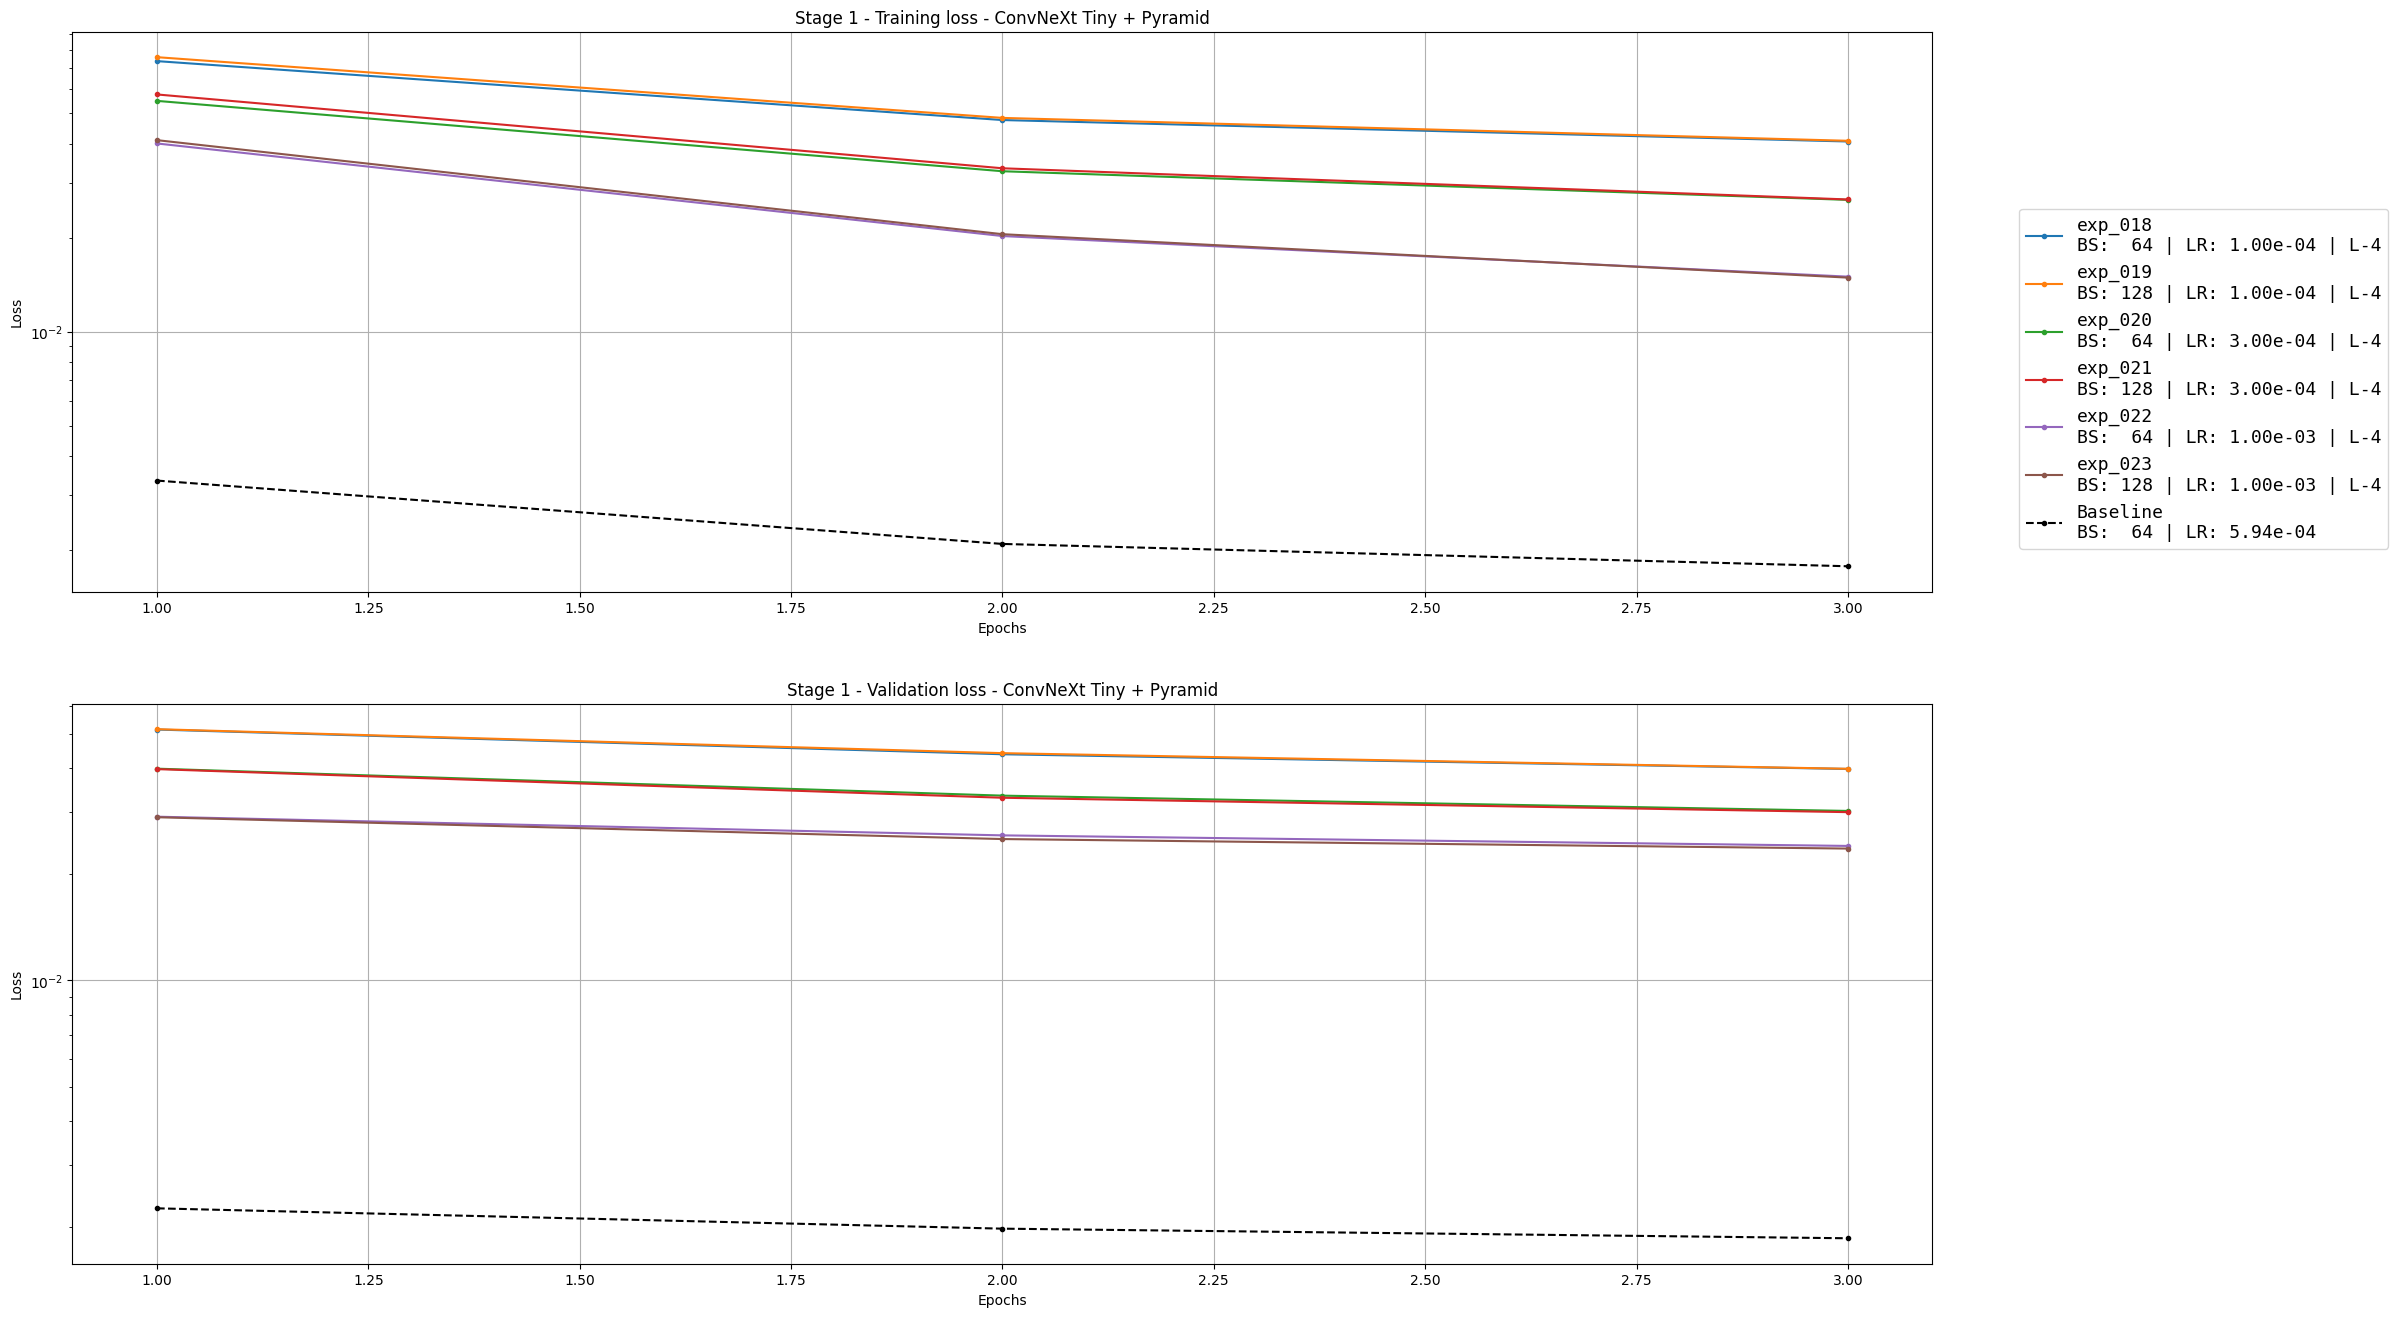

In [21]:
exp_name_list = []
exp_data_list = []

for exp_name, exp_data in exp_data_all["ret_train_pyr"]["convnext_t_s1"].items():
    exp_name_list.append(exp_name)
    exp_data_list.append(exp_data)

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

color_list =\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[0::2]] +\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[1::2]]

color_idx = 0

for exp_idx, (exp_name, exp_data) in enumerate(zip(exp_name_list, exp_data_list)):

    backbone = exp_data["settings"]["backbone"]["class"]
    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = src.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_devices"])
    finished = exp_data["results"]["stage_1"]["finished"]

    act_bs_1 = batch_size_1 * grad_acc_iters_1 * num_gpus
    feat_lvls = [idx + 1 for idx in exp_data["settings"]["head"]["in_feat_idxs"]]

    if len(exp_data["settings"]["head"]["in_feat_idxs"]) != 1:
        continue

    # Title

    title_lines = []

    #title_lines.append("Bkbn: {:s}".format(backbone))
    
    title_lines.append("{:s}".format(exp_name))
    if not finished: title_lines[-1] += " | Unifinished"
    
    title_lines.append("BS: {:3d} | LR: {:3.2e} | L-{:s}".format(
        act_bs_1,
        lr_1,
        "".join([str(lvl) for lvl in feat_lvls])
    ))

    label = "\n".join(title_lines)
    
    # Color

    ## Normal color

    color = color_list[color_idx]
    color_idx += 1

    ## Color by BS

    """
    if act_bs_1 == 64:
        color = color_list[0]
    if act_bs_1 == 128:
        color = color_list[2]
    """

    ## Color by LR

    """
    if lr_1 == 1e-4:
        color = color_list[0]
    if lr_1 == 3e-4:
        color = color_list[2]
    if lr_1 == 1e-3:
        color = color_list[4]
    """

    ## Color by L

    """
    if feat_lvls == [4]:
        color = color_list[0]
    if feat_lvls == [3, 4]:
        color = color_list[1]
    if feat_lvls == [2, 3, 4]:
        color = color_list[2]
    if feat_lvls == [1, 2, 3, 4]:
        color = color_list[3]
    """

    # Plot
    
    mean_train_loss_list =\
        list(map(np.sum, exp_data["results"]["stage_1"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.sum, exp_data["results"]["stage_1"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=label, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=label, color=color, marker=".")

    #axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    #axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

#####
#####

exp_data = exp_data_all["ret_train"]["convnext_t"]["exp_002"]

mean_train_loss_list =\
    list(map(np.sum, exp_data["results"]["stage_1"]["train_mean_loss_list"]))

mean_val_loss_list =\
    list(map(np.sum, exp_data["results"]["stage_1"]["val_mean_loss_list"]))
    
mean_train_loss_list = mean_train_loss_list[:3]
mean_val_loss_list = mean_val_loss_list[:3]

backbone = exp_data["settings"]["backbone"]["class"]
batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
grad_acc_iters_1 = src.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
act_lr_1 = exp_data["settings"]["stage_1"]["base_lr"]
num_gpus = len(exp_data["settings"]["gpu_usage"])
finished = exp_data["results"]["stage_1"]["finished"]

act_bs_1 = batch_size_1 * grad_acc_iters_1 * num_gpus

title_lines = []

#title_lines.append("Bkbn: {:s}".format(backbone))

title_lines.append("Baseline")

title_lines.append("BS: {:3d} | LR: {:3.2e}".format(
    act_bs_1,
    act_lr_1
))

label = "\n".join(title_lines)

axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=label, color="black", marker=".", linestyle="--")
axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=label, color="black", marker=".", linestyle="--")

#####
#####

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].set_title("Stage 1 - Training loss - ConvNeXt Tiny + Pyramid")
axs[1].set_title("Stage 1 - Validation loss - ConvNeXt Tiny + Pyramid")

#

plt.legend(prop={'family': 'monospace', "size": 13}, bbox_to_anchor=(1.25, 1.90))

#

plt.show()

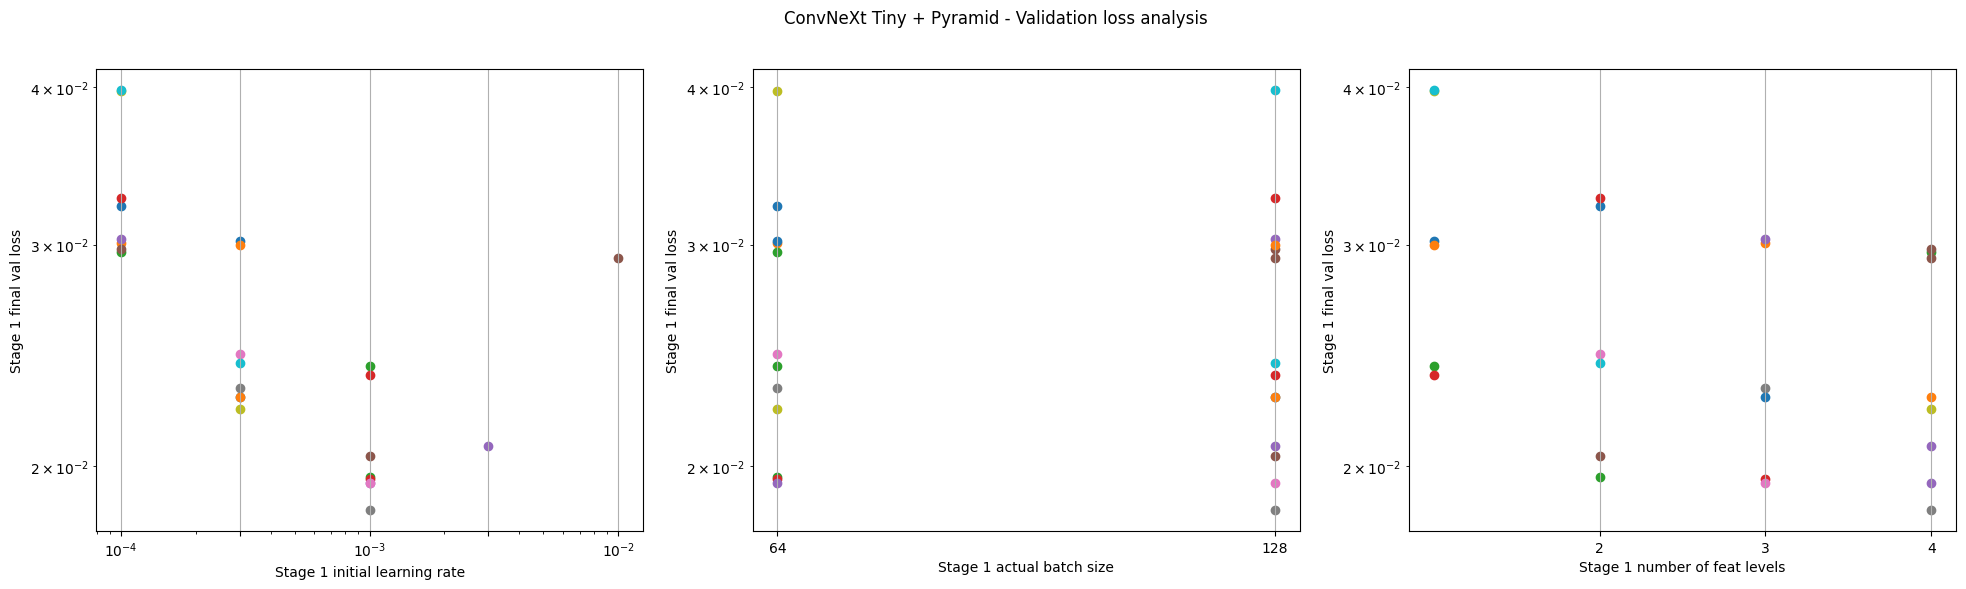

In [7]:
exp_name_list = []
exp_data_list = []

for exp_name, exp_data in exp_data_all["ret_train_pyr"]["convnext_t_s1"].items():
    exp_name_list.append(exp_name)
    exp_data_list.append(exp_data)

#

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

for exp_idx, (exp_name, exp_data) in enumerate(zip(exp_name_list, exp_data_list)):

    backbone = exp_data["settings"]["backbone"]["class"]
    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = src.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_devices"])
    finished = exp_data["results"]["stage_1"]["finished"]
    feat_lvls = [idx + 1 for idx in exp_data["settings"]["head"]["in_feat_idxs"]]

    actual_batch_size_1 = batch_size_1 * grad_acc_iters_1 * num_gpus
    val_loss = sum(exp_data["results"]["stage_1"]["val_mean_loss_list"][-1])

    axs[0].scatter(lr_1, val_loss)
    axs[1].scatter(actual_batch_size_1, val_loss)
    axs[2].scatter(len(feat_lvls), val_loss)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xticks([1e-4, 3e-4, 1e-3, 3e-3, 1e-2])
axs[0].grid(True)

axs[1].set_yscale("log")
axs[1].set_xticks([64, 128])
axs[1].grid(True)

axs[2].set_yscale("log")
axs[2].set_xticks([2, 3, 4])
axs[2].grid(True)

plt.suptitle("ConvNeXt Tiny + Pyramid - Validation loss analysis")

axs[0].set_xlabel("Stage 1 initial learning rate")
axs[0].set_ylabel("Stage 1 final val loss")

axs[1].set_xlabel("Stage 1 actual batch size")
axs[1].set_ylabel("Stage 1 final val loss")

axs[2].set_xlabel("Stage 1 number of feat levels")
axs[2].set_ylabel("Stage 1 final val loss")

plt.show()

In [8]:
data_df = pd.DataFrame({
    "exp_name": pd.Series(dtype="str"),
    "LR": pd.Series(dtype="float"),
    "BS": pd.Series(dtype="int"),
    "Lvls": pd.Series(dtype="str"),
    "val_loss": pd.Series(dtype="float")
})

for exp_idx, (exp_name, exp_data) in enumerate(zip(exp_name_list, exp_data_list)):

    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = src.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_devices"])
    finished = exp_data["results"]["stage_1"]["finished"]
    feat_lvls = [idx + 1 for idx in exp_data["settings"]["head"]["in_feat_idxs"]]

    actual_batch_size_1 = batch_size_1 * grad_acc_iters_1 * num_gpus
    val_loss = sum(exp_data["results"]["stage_1"]["val_mean_loss_list"][-1])

    row = {
        "exp_name": "exp_{:03d}".format(exp_idx),
        "LR": lr_1,
        "BS": actual_batch_size_1,
        "Lvls": "".join(str(lvl) for lvl in feat_lvls),
        "val_loss": val_loss
    }

    data_df.loc[len(data_df)] = row

data_df = data_df.sort_values("val_loss", ascending=False)
data_df = data_df.reset_index()

In [9]:
data_df

,index,exp_name,LR,BS,Lvls,val_loss
0,19,exp_019,0.0001,128,4,0.039783
1,18,exp_018,0.0001,64,4,0.039737
2,3,exp_003,0.0001,128,34,0.032644
3,0,exp_000,0.0001,64,34,0.032212
4,4,exp_004,0.0001,128,234,0.030313
5,20,exp_020,0.0003,64,4,0.030215
6,1,exp_001,0.0001,64,234,0.030066
7,21,exp_021,0.0003,128,4,0.029977
8,5,exp_005,0.0001,128,1234,0.029771
9,2,exp_002,0.0001,64,1234,0.029584


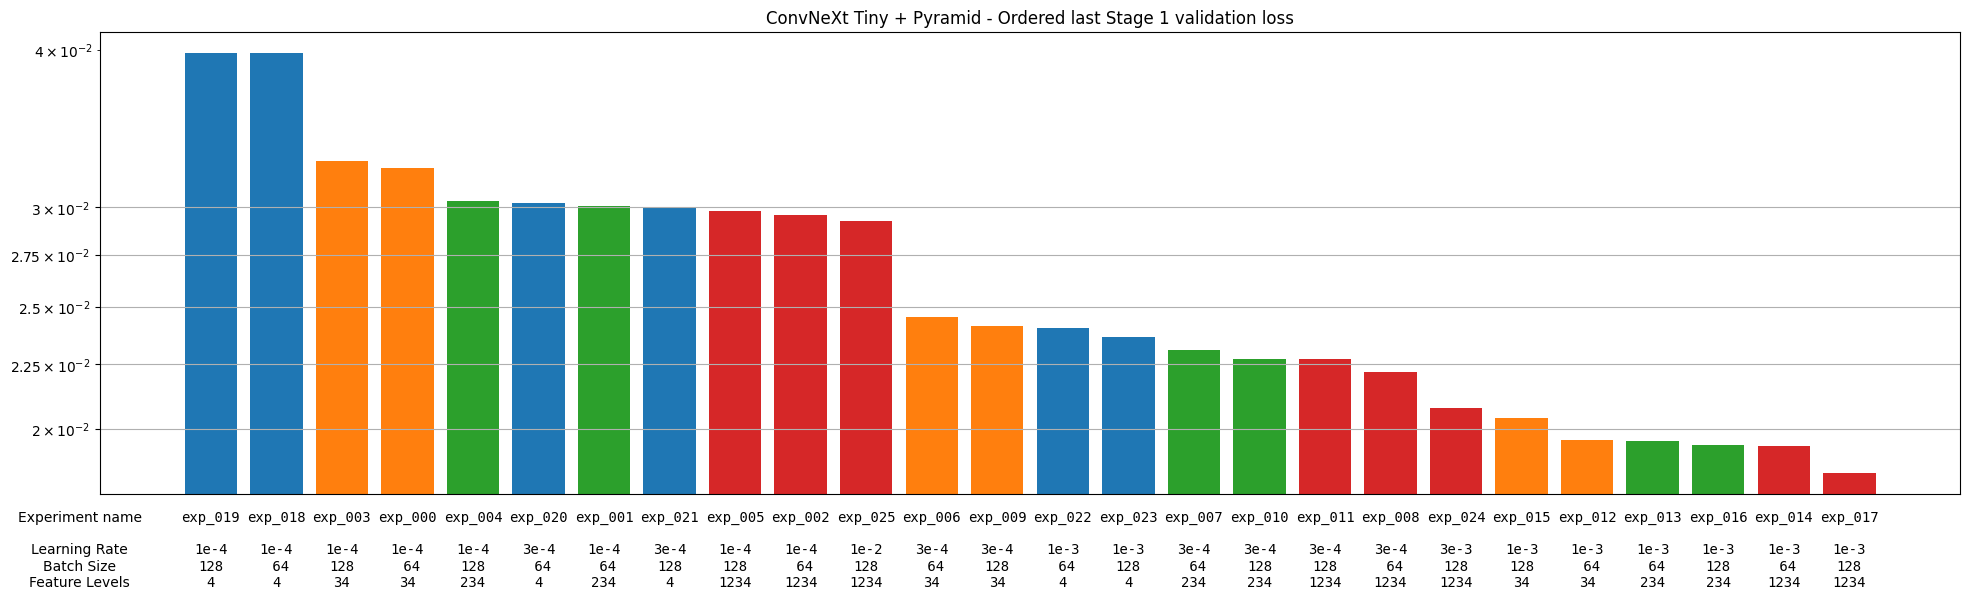

In [10]:
plt.figure(figsize=(24, 6))

###

color_list =\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[0::2]] +\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[1::2]]

## Color by BS

"""
bar_color_list = [color_list[0] for _ in range(len(data_df))]
"""

## Color bt BS

"""
bar_color_list = [
    color_list[0] if bs == 64 else color_list[1]
    for bs in data_df["BS"]
]
"""

## Color bt LR

"""
bar_color_list = [
    color_list[0] if lr == 1e-4 else color_list[1] if lr == 3e-4 else color_list[2]
    for lr in data_df["LR"]
]
"""

## Color by L

bar_color_list = [
    color_list[0] if lvls == "4" else color_list[1] if lvls == "34" else color_list[2] if lvls == "234" else color_list[3]
    for lvls in data_df["Lvls"]
]

###

plt.bar(np.asarray(data_df.index), data_df["val_loss"], color=bar_color_list)
plt.yscale("log")

###

plt.xticks([])
plt.title("ConvNeXt Tiny + Pyramid - Ordered last Stage 1 validation loss")

###

text_height = plt.ylim()[0] * (plt.ylim()[1] / plt.ylim()[0]) ** (-0.20)

text = "{:s}\n\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Learning Rate",
    "Batch Size",
    "Feature Levels"
)
plt.text(-2, text_height, text, ha="center")

for idx in data_df.index:
    text = "{:s}\n\n{:s}\n{:3d}\n{:s}".format(
        data_df.at[idx, "exp_name"],
        np.format_float_scientific(data_df.at[idx, "LR"], exp_digits=1, precision=0, trim="-"),
        data_df.at[idx, "BS"],
        data_df.at[idx, "Lvls"]
    )
    plt.text(idx, text_height, text, ha="center", family="monospace")

###

plt.yticks([3e-2, 2.75e-2, 2.5e-2, 2.25e-2, 2e-2])
plt.grid(True, axis="y")

plt.show()